In [1]:
import numpy as np
import matplotlib.pyplot as plt
import PCA as pca
from scipy.optimize import minimize
from scipy.linalg import cho_factor, cho_solve
import emcee
import corner
%matplotlib inline

In [2]:
from modeling import Model
class SimpleKernel(Model):
    parameter_names = ("log_b", )
    
    def get_value(self, tau):
        a = 1.0
        b = np.exp(self.log_b)
        return a * np.exp(-b * tau**2)
    
    def get_grad_1_value(self, tau):
        a = 1.0
        b = np.exp(self.log_b)
        return 2 * a * b * tau * np.exp(-b * tau**2)
    
    def get_grad_2_value(self, tau):
        a = 1.0
        b = np.exp(self.log_b)
        return 2 * a * b * np.exp(-b * tau**2) * (1.0 - 2 * b * tau**2)

# This model 
class RVKernel(Model):
    parameter_names = ("vc", "vr", "lc", "lr", "bc", "br")
    
    def __init__(self, G1, G2, *args, **kwargs):
        self.G1 = G1
        self.G2 = G2
        super(RVKernel, self).__init__(*args, **kwargs)
    
    def get_value(self, tau, l1, l2):
        vc = self.vc
        vr = self.vr
        lc = self.lc
        lr = self.lr
        bc = self.bc
        br = self.br
        
        # Compute the value of gamma and its derivatives
        g1 = self.G1.get_value(tau)
        g2 = self.G2.get_value(tau)
        
        # We'll use these masks to build the blocked kernel matrix
        m11 = l1 == 1
        m12 = l1 == 2
        m13 = l1 == 3
        m21 = l2 == 1
        m22 = l2 == 2
        m23 = l2 == 3
        
        # Allocate the matrix and loop over blocks
        K = np.zeros_like(tau)
        zero_tau = np.isclose(tau, 0.0)
        
        # k11
        m = m11 * m21
        K[m] = vc**2*g1[m] + vr**2*g2[m]
        m &= zero_tau

        # k22
        m = m12 * m22
        K[m] = lc**2*g1[m] + lr**2*g2[m]
        m &= zero_tau

        # k33
        m = m13 * m23
        K[m] = bc**2*g1[m] + br**2*g2[m]
        m &= zero_tau

        # k12
        m = m11 * m22
        K[m] = vc*lc*g1[m] + vr*lr*g2[m]
        m = m12 * m21
        K[m] = vc*lc*g1[m] + vr*lr*g2[m]

        # k13
        m = m11 * m23
        K[m] = vc*bc*g1[m] + vr*br*g2[m]
        m = m13 * m21
        K[m] = vc*bc*g1[m] + vr*br*g2[m]

        # k23
        m = m12 * m23
        K[m] = lc*bc*g1[m] + lr*br*g2[m]
        m = m13 * m22
        K[m] = lc*bc*g1[m] + lr*br*g2[m]

        return K

In [4]:
# Get PCA of simulated spectra
dir_ = "simulated_spectra/"   # data directory
pcs = 3                       # number of pca components
WL = (3924, 6662)             # single range

x, v, z_raw, xs_hat, x_hat, wavelengths, ev = pca.do_PCA(dir_, WL, pcs, 1)
phases_raw = np.load('files/phases.npy')

Successfully loaded files
3 PCs explain 0.997743 of the variance for wavelimits:. (3924, 6662)


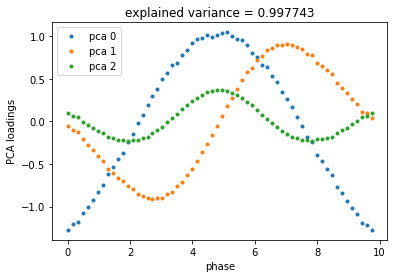

In [5]:
def prep_data(phases, z, rescale_fac, l1=-np.inf, l2=np.inf, re_center=1):
    
    # grab phases of interest
    index = (phases > l1) & (phases < l2)
    phases = phases[index]
    phases -= np.min(phases)
    phases *= 20
    z = z[index]
    z = z/rescale_fac
    
    if re_center == 1: # after removing baseline points, GP requires 0 mean
        for i in range(z.shape[1]):
            z[:,i] -= np.mean(z[:,i])
    return phases, z

phases, z = prep_data(phases_raw, z_raw, 500, -0.25, 0.25)

for i in range(pcs):
    plt.plot(phases, z[:,i], '.', label='pca %d'%i)
plt.ylabel('PCA loadings')
plt.xlabel('phase')
plt.title('explained variance = %f'%ev)
plt.legend()

In [6]:
# Prepare Data
n = len(z)

# indices
l = np.zeros(0)
p = np.zeros(0)
y = np.zeros(0)
for i in range(pcs):
    l = np.concatenate((l, np.ones(n)*(i+1)))
    p = np.concatenate((p, phases))
    y = np.concatenate((y, z[:, i]))

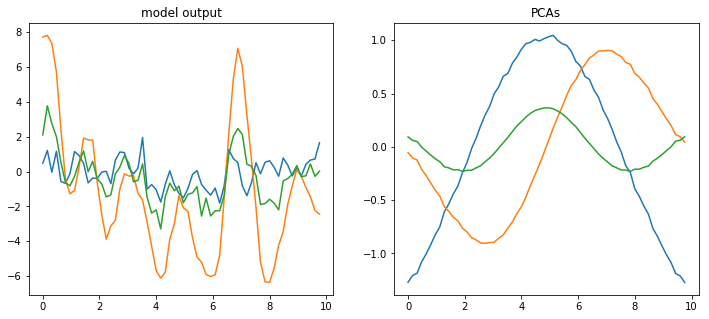

In [41]:
# initial conditions/priors setting
y_sample_true = [3, 1, 1, 0.1, 0.3, 3, 0.5, 1]
func1 = SimpleKernel(y_sample_true[0])
func2 = SimpleKernel(y_sample_true[1])
kernel = RVKernel(func1, func2, y_sample_true[2:])

K = kernel.get_value(p[:, None] - p[None, :], l[:, None], l[None, :])
K[np.diag_indices(len(p))] += 0.1
y_sample = np.random.multivariate_normal(np.zeros_like(p), K)

f, (ax1, ax2) = plt.subplots(1,2, figsize=[12,5])
for i in [1, 2, 3]:
    ax1.plot(p[l==i], y_sample[l==i])
    ax2.plot(p[l==i], y[l==i])
    ax1.set_title('model output')
    ax2.set_title('PCAs')
    
#np.save("y_sample.npy", y_sample)

In [42]:
# def log_prior(params):
#     logL1, logL2, logvc, logvr, loglc, loglr, logbc, logbr = params
#     if (-5<logL1<2 and -5<logL2<2 and -5<logvc<2 and -5<logvr<2 
#         and -5<loglc<2 and -5<loglr<2 and -5<logbc<2 and -5<logbr<2):
#         return 0   
#     return -np.inf 

def log_prior(params):
    L1, L2, vc, vr, lc, lr, bc, br = params
    minL, maxL = 0, 4   
    minp, maxp = 0, 4
    if (minL<L1<maxL and minL<L2<maxL and minp<vc<maxp and minp<vr<maxp 
        and minp<lc<maxp and minp<lr<maxp and minp<bc<maxp and minp<br<maxp):
        return 0   
    return -np.inf 

def log_prob(params, y, p, l):
    lnp = log_prior(params)
    if not np.isfinite(lnp):
        return -np.inf
    func1.set_parameter_vector(params[0])
    func1.set_parameter_vector(params[1])
    kernel.set_parameter_vector(params[2:])
    K = kernel.get_value(p[:, None] - p[None, :], l[:, None], l[None, :])
    K[np.diag_indices_from(K)] += 0.1
    try:
        L = cho_factor(K, overwrite_a=True)
    except (np.linalg.LinAlgError, ValueError):
        return -np.inf
    logdet = 2.0 * np.sum(np.log(np.diag(L[0])))
    ll = -0.5 * (np.dot(y, cho_solve(L, y)) + logdet)
    if not np.isfinite(ll):
        return -np.inf
    return ll

In [45]:
# set up sampler
nwalkers, nsteps = 100, 2000
ndim = func1.vector_size + func2.vector_size + kernel.vector_size
#ini = np.concatenate((func1.get_parameter_vector(), func2.get_parameter_vector(), kernel.get_parameter_vector())) 
ini = np.array((1, 0.1, 0.5, 0.5, 0.1, 0.5, 0.2, 0.3))
ini = 1e-4*np.random.randn(nwalkers, len(ini))

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=(y_sample, p, l))
#sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=(y, p, l))

In [47]:
# Run!
for i, (pos, lnp, state) in enumerate(sampler.sample(ini, iterations=nsteps)):
    if (i+1) % (nsteps/10) == 0:
        print("{0:.1f}%".format(100 * float(i) / nsteps), end=", ")
np.save("emcee_chain_twolatent_sample.npy", sampler.chain)

/storage/work/ajs725/conda/install/lib/python3.6/site-packages/emcee/ensemble.py:335: RuntimeWarning: invalid value encountered in subtract
  lnpdiff = (self.dim - 1.) * np.log(zz) + newlnprob - lnprob0
/storage/work/ajs725/conda/install/lib/python3.6/site-packages/emcee/ensemble.py:336: RuntimeWarning: invalid value encountered in greater
  accept = (lnpdiff > np.log(self._random.rand(len(lnpdiff))))


9.9%, 19.9%, 29.9%, 40.0%, 50.0%, 60.0%, 70.0%, 80.0%, 90.0%, 100.0%, 

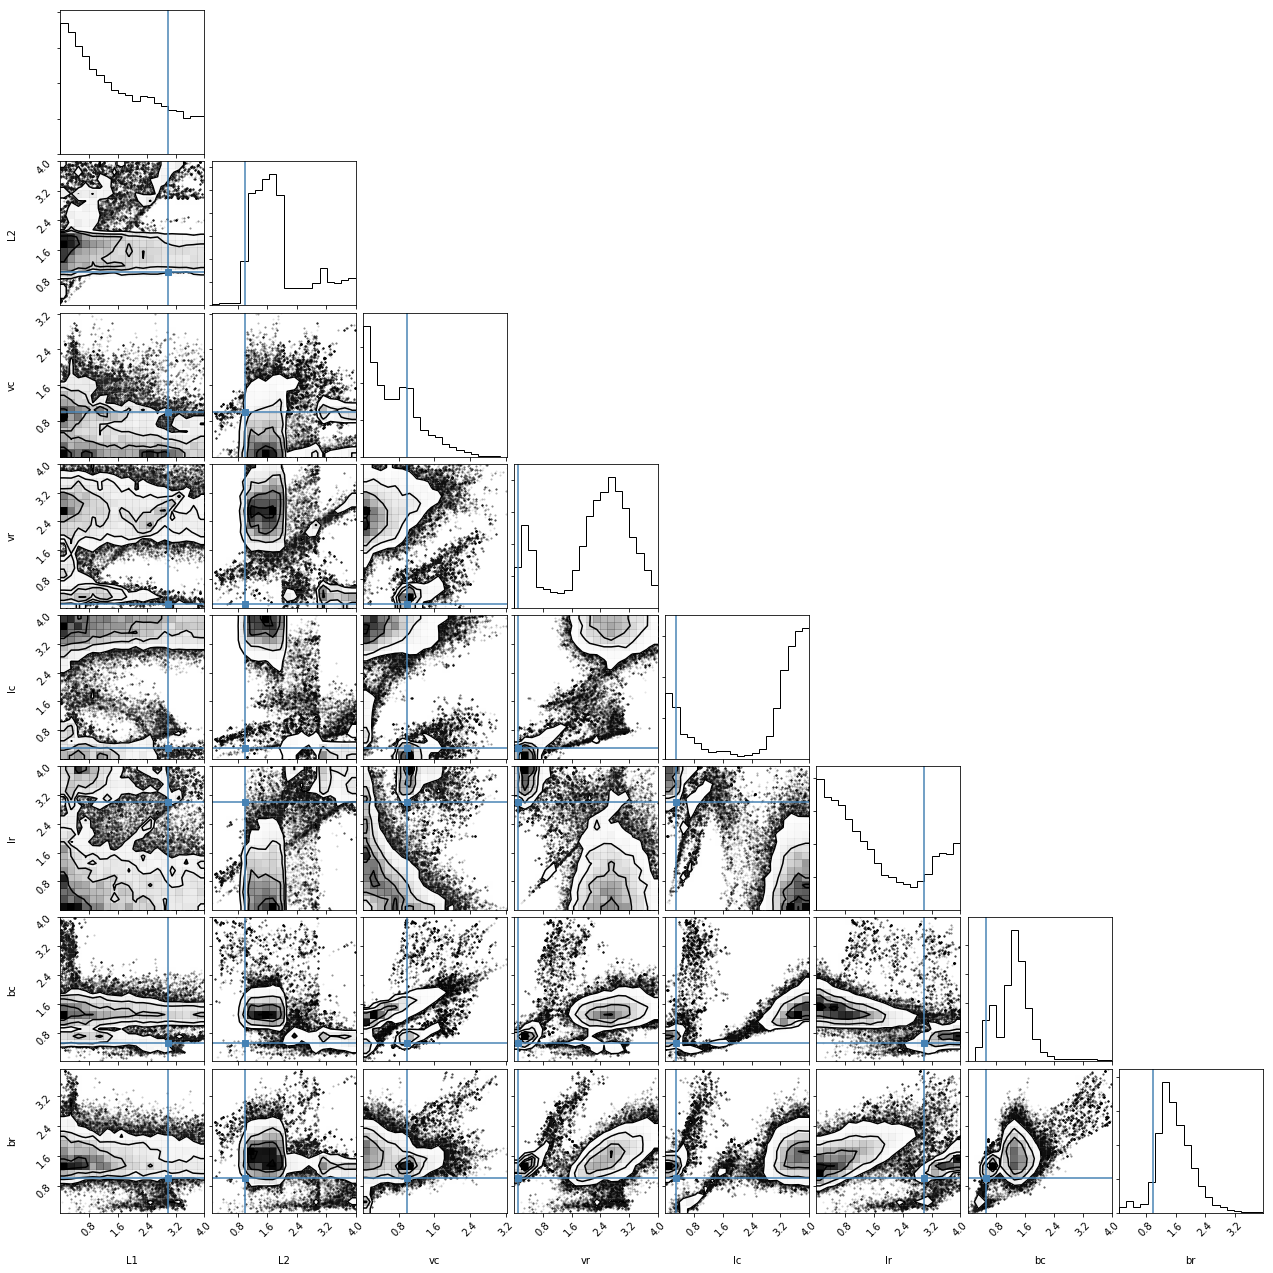

In [52]:
try:
    samples = sampler.chain[:, 100:, :].reshape((-1, ndim))
except:
    samples = np.load("emcee_chain_twolatent_sample.npy")[:, 100:, :].reshape((-1, ndim))
fig = corner.corner(samples, labels=["L1", "L2", "vc", "vr", "lc", "lr","bc", "br"], truths=y_sample_true)
plt.savefig("images/corner_twolatent_ysample2.png")

In [ ]:
3, 1, 1, 0.1, 0.3, 3, 0.5, 1

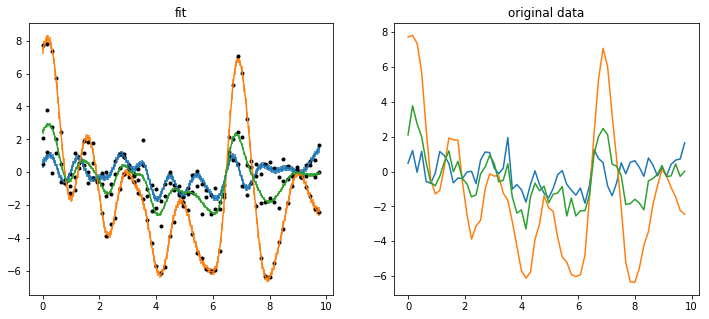

In [50]:
MAP, hi, lo = np.array(list(map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
                                zip(*np.percentile(samples, [16, 50, 84],axis=0))))).T

func1.set_parameter_vector(MAP[0])
func2.set_parameter_vector(MAP[1])
kernel.set_parameter_vector(MAP[2:])

x = np.linspace(0, np.max(p), 200)
# test points
xl = np.zeros(0)
xp = np.zeros(0)
for i in range(pcs):
    xp = np.concatenate((xp, x))
    xl = np.concatenate((xl, np.ones(len(x))*(i+1)))

K = kernel.get_value(p[:, None] - p[None, :], l[:, None], l[None, :])
Ks = kernel.get_value(xp[:, None] - p[None, :], xl[:, None], l[None, :])
Kx = kernel.get_value(xp[:, None] - xp[None, :], xl[:, None], xl[None, :]) 
K[np.diag_indices(len(p))] += 0.1

#mu = np.dot(Ks, np.linalg.solve(K, y))
mu = np.dot(Ks, np.linalg.solve(K, y_sample))
sigma_cov = Kx - np.dot(Ks, np.linalg.solve(K, Ks.T)) #covariance matrix for predictions
sigma = np.sqrt(np.diag(sigma_cov))

f, (ax1, ax2) = plt.subplots(1,2, figsize=[12,5])
#y_plt = y
y_plt = y_sample
for i in range(3):
    ax1.plot(p[l==i+1], y_plt[l==i+1], "k.");
    ax1.errorbar(xp[xl==i+1], mu[xl==i+1], yerr=sigma[xl==i+1])
    ax2.plot(p[l==i+1], y_plt[l==i+1])
    ax1.set_title("fit")
    ax2.set_title("original data")

plt.savefig("images/emcee_fit_twolatent_ysample.png")